**PREAMBLE**

*   **Goal**: calibrate the model and retain uncertainty about its parameters.
*   **Method**: We do so by mapping the behavior of the model to a set of summary statistics by using an aritificial neural network, to then use these summary statistics within an approximate Bayesian inference framework.

**Model** 

$y = f(x,\theta,\epsilon)$, with $x$ the input to the model, $\theta$ the parameters of the model, $\epsilon$ a noise term, and $y$ the output.

We assume that an observation of the model output (or of the natural system that the model wants to represent) $y_{obs}$ is available.

**Idea** 

Since $y$ and $y_{obs}$ are in general very high dimensional (potentially both in time and space) we want to compare a low dimensional transformation of $y$ and $y_{obs}$, meaning, we want to substitite $y$ and $y_{obs}$ by a small set of summary statistics $\{s_1,...,s_q\}$, with $s_i = g_i(y) = g_i(f(x,θ,ϵ))$ and $s_{i,obs} = g_i(y_{obs})$.

Theory suggests that *q ≥ p*, where *p* is the number of parameters of the model in order to be able to discern the effect of different model's parameters and avoid degeneracy.

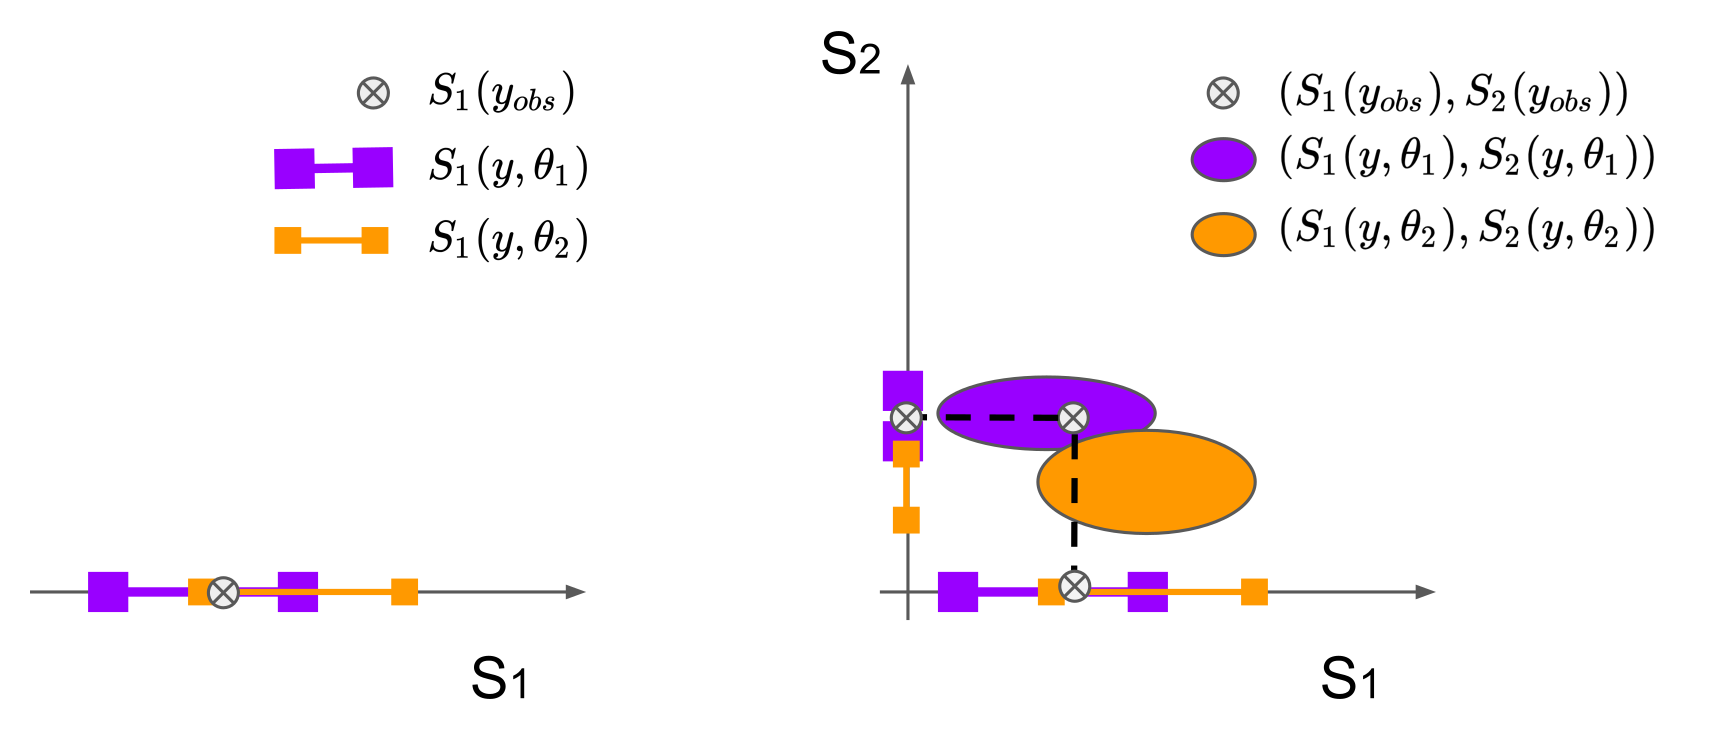

**How to do so**


1.   We train an artificial neural network (an autoencoder) to learn the regressions: $s_i = g_i(y) = g_i(f(x,θ,ϵ))$ (and potentially extra order parameters if $q > p$).
2.   We use approximate Bayesian computation (simulated annealing approximate Bayesian computation, SABC) to calibrate the model given observations.




**1. AutoEncoder**

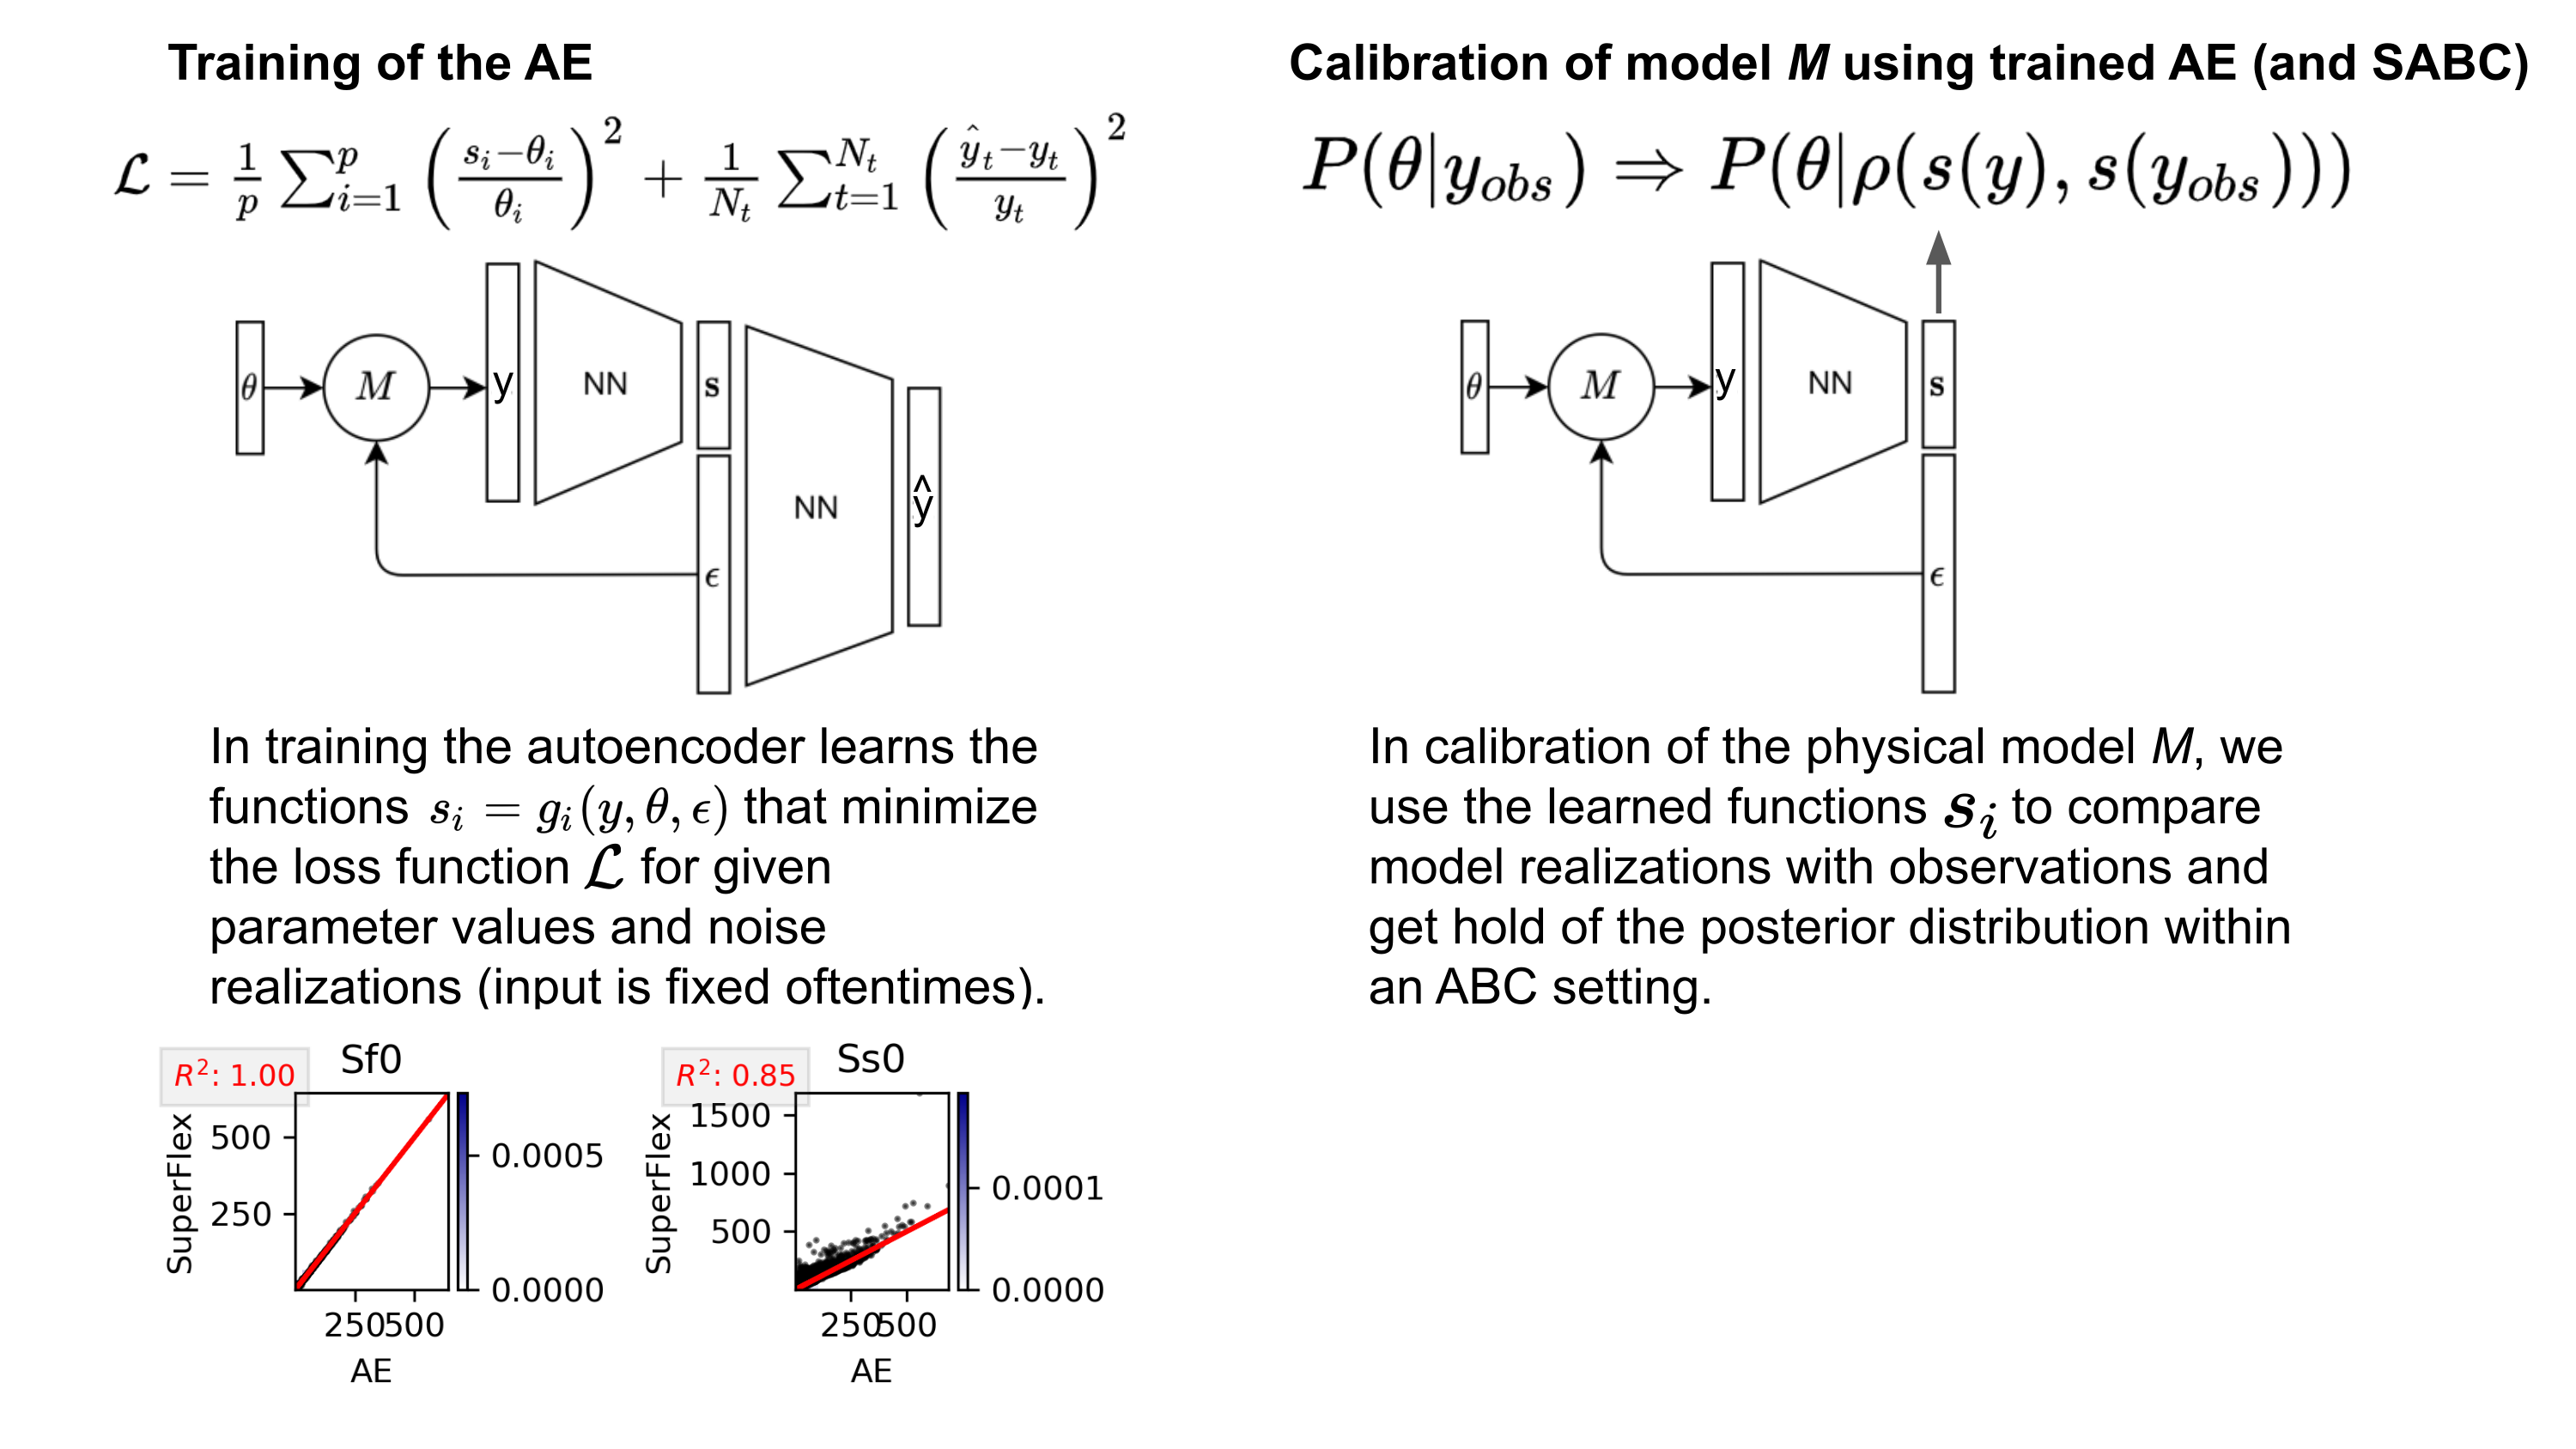

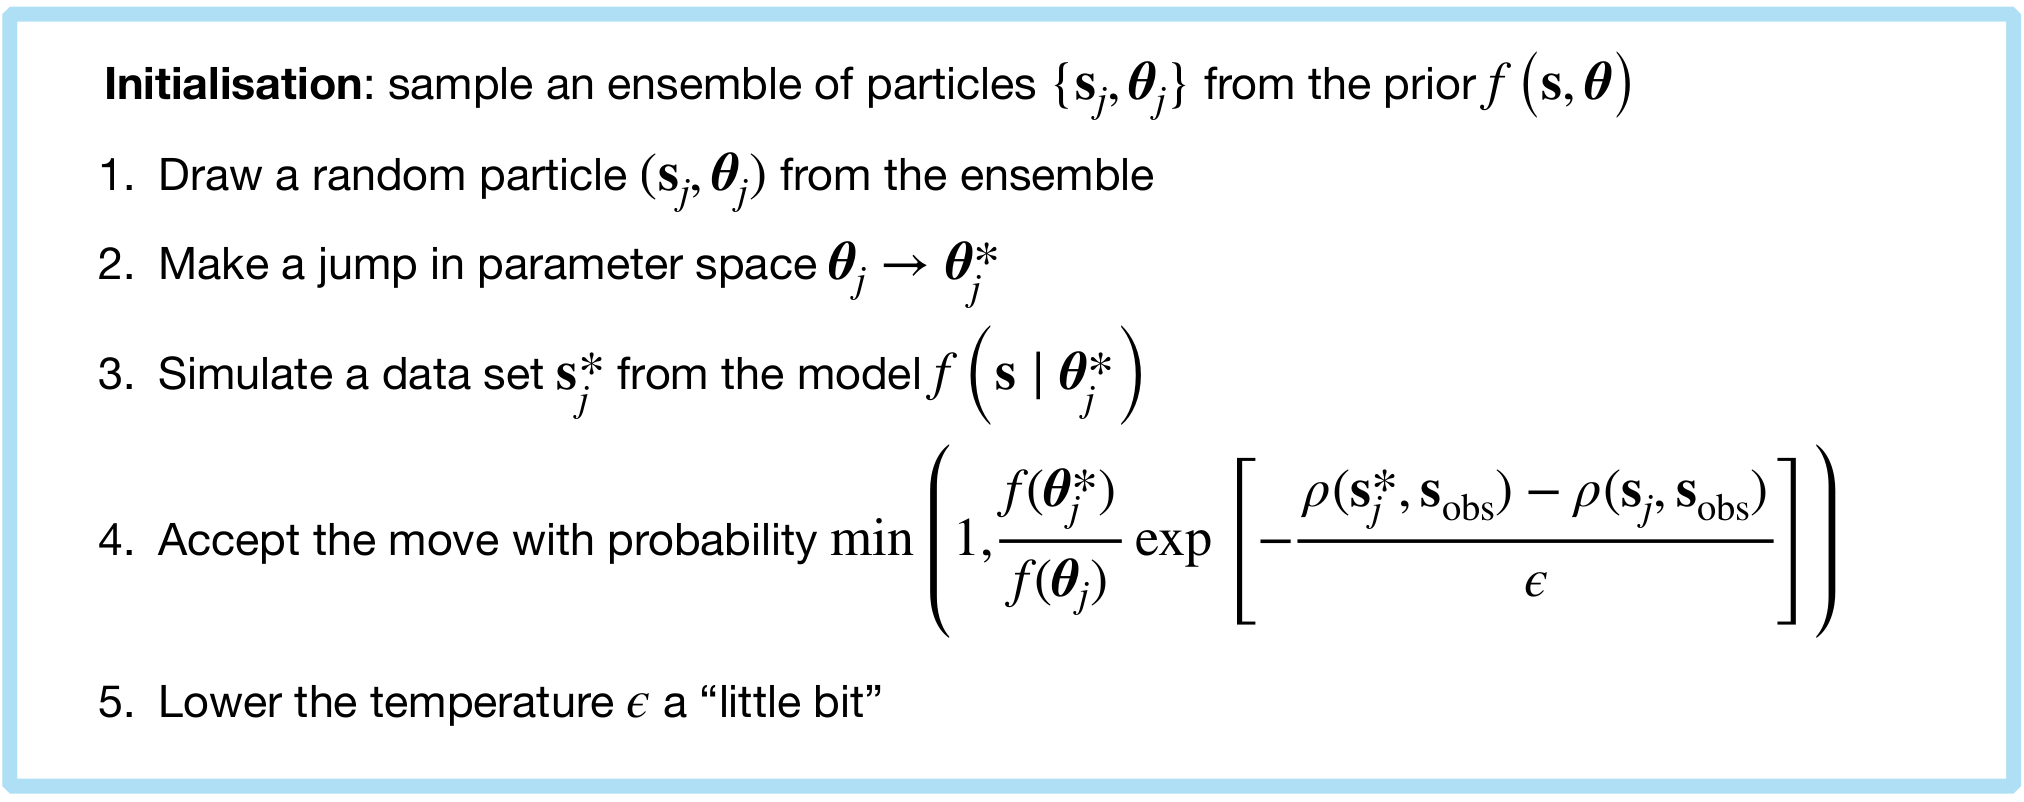

We start by going into the right folder and cloning the ad-hoc repository

In [ ]:
%cd /content
%ls
!if [[ ! -d /content/usi_abcae ]]; then git clone https://gitlab.com/baccione/usi_abcae.git; fi
%cd /content/usi_abcae
!git pull 

We change folder to the folder where we will train the AE and remove the folder "train_weights" if present.

In [ ]:
%cd /content/usi_abcae/Ex_NLAR1/OLD_FRAMEWORK/Train
!if [[ -d train_weights ]]; then rm -r train_weights; fi
!ls

We export the paths for Python to use seamlessly our code ("#" are commented lines)

In [ ]:
%env PYTHONPATH="/env/python:/content/usi_abcae/CODE_AE:/content/usi_abcae/CODE_SPUX:"
# import sys
# for p in ["/content/usi_abcae/CODE_AE","/content/usi_abcae/CODE_SPUX"]:
#   sys.path.append(p)
# print(sys.path)
# from spux import distributions

We now train the autoencoder for a model that reads $y_{t+1} = \alpha \, y_t^2 \, exp(y) + σ\epsilon$ with $\epsilon \sim N(0,1)$ (this model is selected by command line argument "--umodlcl"). It will take some minutes (< 10 minutes).

In [ ]:
!python3 train_AE_tfv2_NLAR1_BiLSTM.py --batch_size 10 --len_timeseries 100 --max_training_steps 200 --aem2load BiLSTM --umodlcl NLAR_SquaredExp --logdir=train_weights
!ls train_weights

Once having listed the folder where the weights of the trained AE are, we  change directory to the one where we perform the calibration with SABC, and we install a Python package for parallel computations (mpi4py).

In [ ]:
%cd /content/usi_abcae/Ex_NLAR1/OLD_FRAMEWORK/Infer
!which mpiexec
!mpiexec --version
!python3 -m pip install mpi4py

We remove some folders, and we list one folder where weights from a better training performed offline (took some hours) are stored, and which we will actually use for inference.

In [ ]:
!if [[ -d output_dev_marco ]]; then rm -r output_dev_marco/; fi
!if [[ -d fig ]]; then rm -r output_dev_marco/; fi
!ls
!echo "-----"
!ls ae_weights_ENCA_BiLSTM

We lauch a very short the inference and we wait for it to finish (< 10 minutes).

In [ ]:
!mpiexec --allow-run-as-root -n 3 python3 -m mpi4py infer_dev_marco.py --logdir=ae_weights_ENCA_BiLSTM --varstats_file homogen.dat --varstats_file homogen.dat

We plot the results

In [ ]:
!python3 plot_results.py --logdir=ae_weights_ENCA_BiLSTM --varstats_file homogen.dat

With a long-enough training and a long-enough inference, results would look like the ones below.

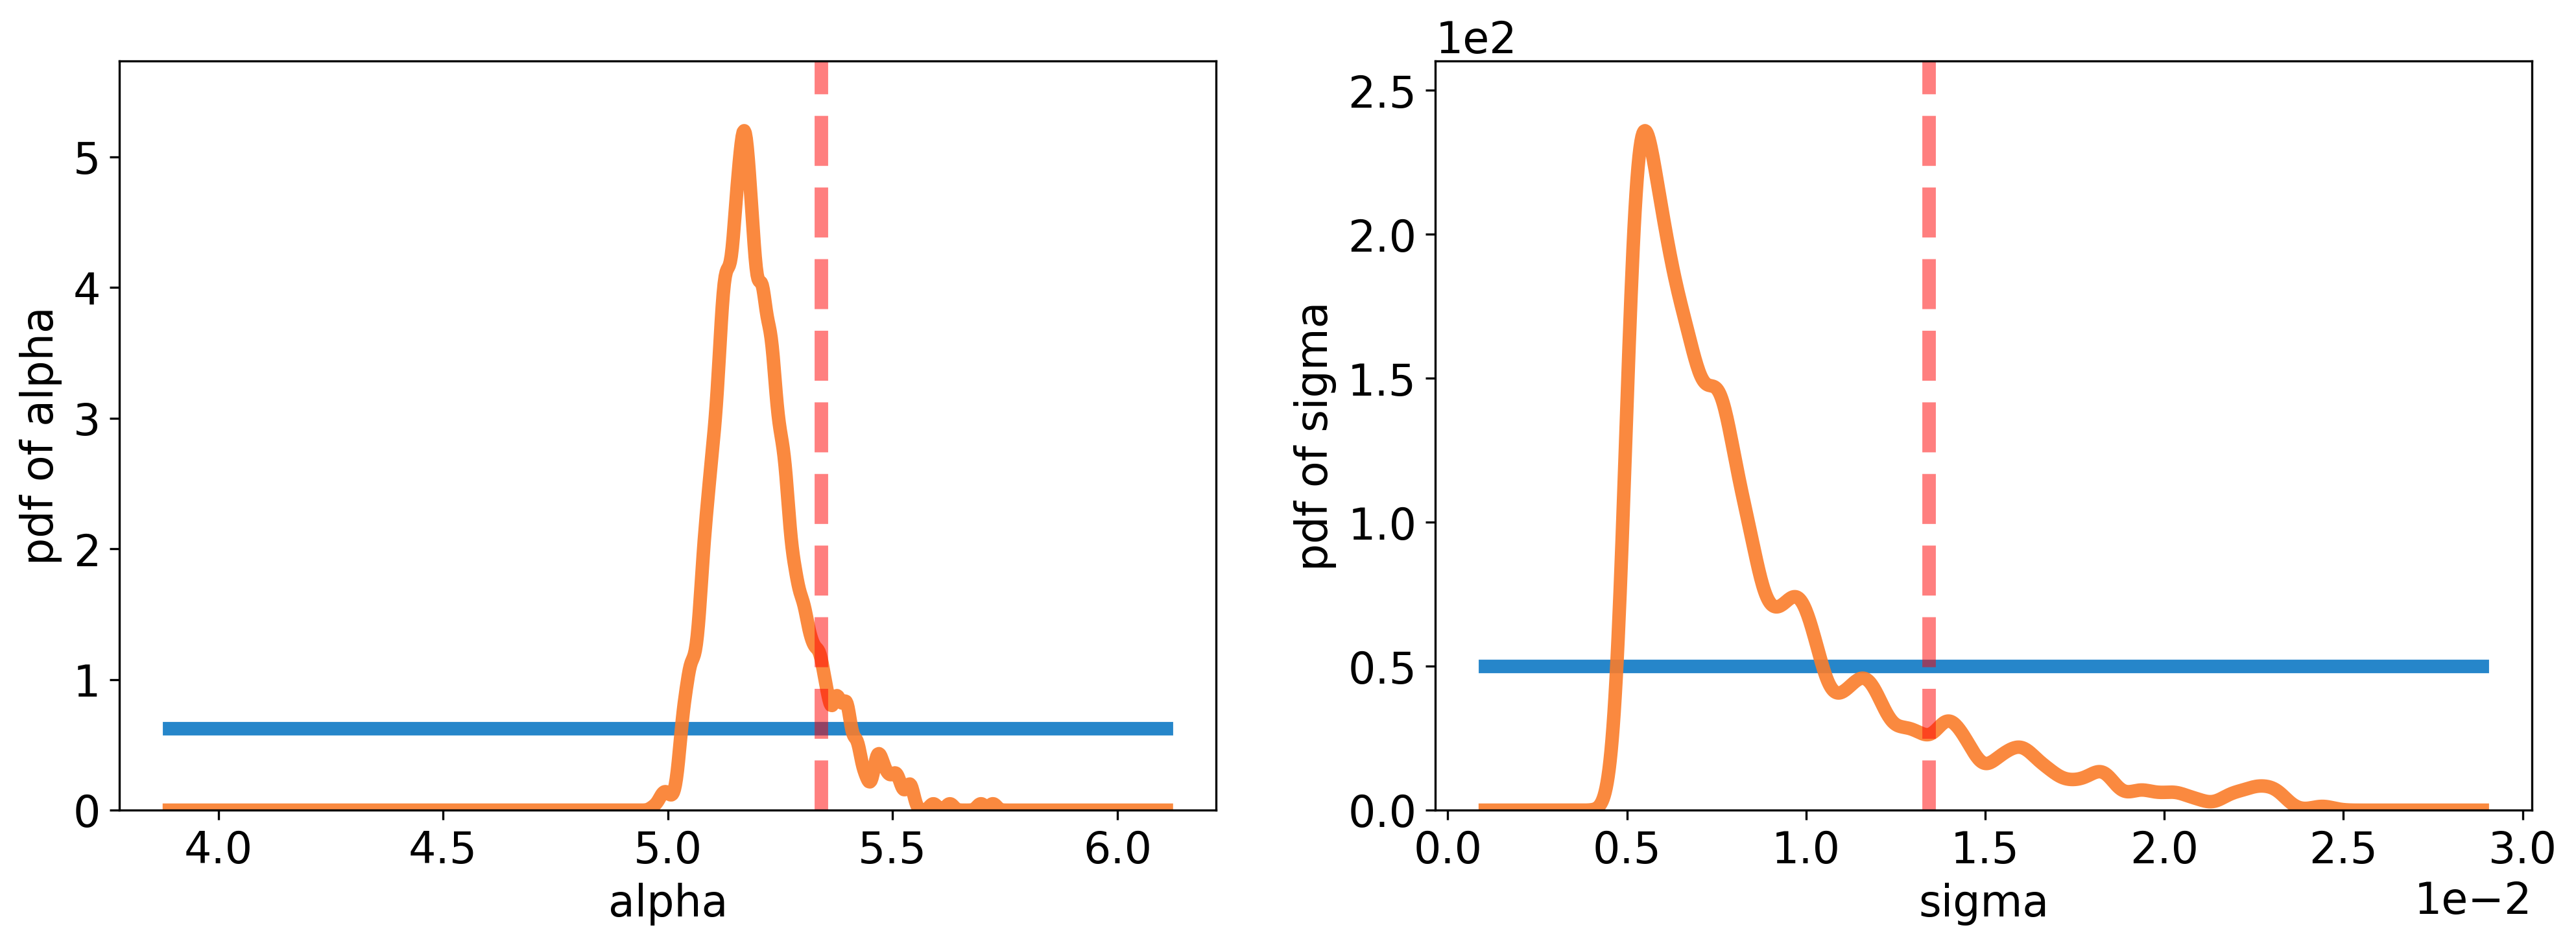



---


Our framework is a dynamic object, and I have recently re-reshaped the code such that it can be operated through a key-file. For example, key-file key_train.txt in folder /content/usi_abcae/Ex_NLAR1/NEW_FRAMEWORK looks like:

LOGDIR  ae_weights_ENCA_BiLSTM           # path to traing weights dir or inference output

LEN_TIMESERIES  100                      # length of timeseries

PRIORINFL prior_train.in

ADD2PYPATH 1

PYPATH /content/usi_abcae/CODE_AE /content/usi_abcae/CODE_SPUX

BATCH_SIZE 10

UMODLFN NLAR1_SquaredExp 

DOTRAIN 1

MAX_TRAINING_STEPS 300

LINEAR_WARMUP_STEPS 100

To try the new framework, we change directory, remove the potentially present old directory "ae_weights_ENCA_BiLSTM", and run the training with the "python3" command below.

In [ ]:
%cd /content/usi_abcae/Ex_NLAR1/NEW_FRAMEWORK
%ls
!if [[ -d ae_weights_ENCA_BiLSTM ]]; then rm -r ae_weights_ENCA_BiLSTM/; fi
!python3 /content/usi_abcae/CODE_AE/ae_src/simple.py -k key_train.txt

We finally remove a potentially old trajectory with possibly old inference results, and we run the inference with the "mpiexec" command below.

In [ ]:
!if [[ -d output_dev_marco ]]; then rm -r output_dev_marco/; fi
%ls
!mpiexec --allow-run-as-root -n 3 python3 -m mpi4py /content/usi_abcae/CODE_AE/ae_src/simple.py -k key_infer.txt

Automatic plotting routines are not yet available. Here an Rscript that plot the posterior density (or at least, tries).

In [ ]:
!Rscript Rplot.R
!ls